# ABOUT DATA SET

Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import statsmodels
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# function to perform post-hoc test
import statsmodels.stats.multicomp as mc
# import function to perform post-hoc
# install scikit_posthocs using "!pip install scikit_posthocs" 
import scikit_posthocs


# import the functions to perform Chi-square tests
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare

# Data Loading

In [3]:
data=pd.read_csv(r'D:/bigmart_sales_train.csv') 

In [4]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052



|Variable|Description|
|:- |:-| 
|
|<strong>Numerical variables</strong>|
|
|Item_Weight|Weight of product
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product
|Item_MRP|Maximum Retail Price (list price) of the product
|Item_Outlet_Sales|Sales of the product in the particular store. This is the outcome variable to be predicted.
|
|<strong>Categorical variables</strong>
|
|Item_Identifier|Unique product ID
|Item_Fat_Content|Whether the product is low fat or not
|Item_Type|The category to which the product belongs
|Outlet_Identifier|Unique store ID
|Outlet_Establishment_Year|The year in which store was established
|Outlet_Size|The size of the store in terms of ground area covered
|Outlet_Location_Type|The type of city in which the store is located
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket
|Item_Outlet_Sales|Sales of the product in the particular store. This is the outcome variable to be predicted.

# Shape of the Data

In [5]:
data.shape

(8523, 12)

# Checking null values

In [6]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

# Type conversion as per requirement

In [7]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [8]:
data['Outlet_Establishment_Year']=data['Outlet_Establishment_Year'].astype('object')
data.dtypes


Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year     object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

# Data modification and creating new columns

In [9]:
data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [10]:
fat={'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'}
data.Item_Fat_Content.replace(fat,inplace=True)
data.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [11]:
new=data["Item_Identifier"].apply(lambda x:x[:2])
new.head()

0    FD
1    DR
2    FD
3    FD
4    NC
Name: Item_Identifier, dtype: object

In [12]:
data['Item_Identifier_type']=new
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC


# Imputing missing values

checking nullvalues for outlet size

In [13]:
pd.crosstab(index= data['Outlet_Location_Type'],columns=data['Outlet_Type'],dropna=False,)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,,,,
Tier 1,528,1860,0,0
Tier 2,0,2785,0,0
Tier 3,555,932,928,935


In [14]:
pd.crosstab(data['Outlet_Type'].replace(np.nan, 'NaN'),data['Outlet_Size'].replace(np.nan, 'NaN'),dropna=False)

Outlet_Size,High,Medium,NaN,Small
Outlet_Type,,,,
Grocery Store,0,0,555,528
Supermarket Type1,932,930,1855,1860
Supermarket Type2,0,928,0,0
Supermarket Type3,0,935,0,0


In [15]:
pd.crosstab(data['Outlet_Location_Type'].replace(np.nan, 'NaN'),data['Outlet_Size'].replace(np.nan, 'NaN'),dropna=False)

Outlet_Size,High,Medium,NaN,Small
Outlet_Location_Type,,,,
Tier 1,0,930,0,1458
Tier 2,0,0,1855,930
Tier 3,932,1863,555,0


By above crosstable observation we can impute the outlet size with small

In [16]:
 data['Outlet_Size'] = data['Outlet_Size'].fillna('Small')

# checking nullvalues for item weight

In [17]:
data.sort_values(["Item_Identifier", "Item_Weight"], ascending = (False, True))

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
214,NCZ54,14.650,Low Fat,0.000000,Household,161.5552,OUT010,1998,Small,Tier 3,Grocery Store,324.9104,NC
1969,NCZ54,14.650,Low Fat,0.083528,Household,162.4552,OUT045,2002,Small,Tier 2,Supermarket Type1,2274.3728,NC
2839,NCZ54,14.650,Low Fat,0.083359,Household,161.9552,OUT046,1997,Small,Tier 1,Supermarket Type1,4711.2008,NC
7738,NCZ54,14.650,Low Fat,0.083699,Household,163.4552,OUT018,2009,Medium,Tier 3,Supermarket Type2,2599.2832,NC
7926,NCZ54,14.650,Low Fat,0.083489,Household,161.3552,OUT049,1999,Medium,Tier 1,Supermarket Type1,7148.0288,NC
1896,NCZ54,NaN,Low Fat,0.082956,Household,164.0552,OUT027,1985,Medium,Tier 3,Supermarket Type3,5523.4768,NC
7166,NCZ54,NaN,Low Fat,0.145952,Household,160.9552,OUT019,1985,Small,Tier 1,Grocery Store,162.4552,NC
1267,NCZ53,9.600,Low Fat,0.024577,Health and Hygiene,186.6214,OUT018,2009,Medium,Tier 3,Supermarket Type2,1884.2140,NC
3959,NCZ53,9.600,Low Fat,0.024457,Health and Hygiene,186.6214,OUT013,1987,High,Tier 3,Supermarket Type1,3203.1638,NC
4924,NCZ53,9.600,Low Fat,0.040970,Health and Hygiene,188.7214,OUT010,1998,Small,Tier 3,Grocery Store,376.8428,NC


By seeing above table we can observe that same item will have same weight,so we can impute with the value of item weight


In [18]:
data["Item_Weight"] = data.groupby("Item_Identifier",sort=False)["Item_Weight"].apply(lambda x: x.fillna(x.mean()))
data.isnull().sum()

Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Identifier_type         0
dtype: int64

In [19]:
data['Item_Weight'] = data['Item_Weight'].fillna(0)
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Identifier_type         0
dtype: int64

# DESCRIPTIVE STATISTICS
Measures of Central Tendency¶

# Statistical Summary using .describe method

In [20]:
#Numerical columns
data_num=data.iloc[:,[1,3,5,11]]
data_num.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
0,9.30,0.016047,249.8092,3735.1380
1,5.92,0.019278,48.2692,443.4228
2,17.50,0.016760,141.6180,2097.2700
3,19.20,0.000000,182.0950,732.3800
4,8.93,0.000000,53.8614,994.7052


In [21]:
#Description of numerical columns
data_num.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.869378,0.066132,140.992782,2181.288914
std,4.653372,0.051598,62.275067,1706.499616
min,0.000000,0.000000,31.290000,33.290000
25%,8.785000,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


# DESCRIPTIVE STATISTICS
Measures of Central Tendency¶

In [22]:
data_num.mean()

Item_Weight            12.869378
Item_Visibility         0.066132
Item_MRP              140.992782
Item_Outlet_Sales    2181.288914
dtype: float64

In [23]:
data_num.median()

Item_Weight            12.600000
Item_Visibility         0.053931
Item_MRP              143.012800
Item_Outlet_Sales    1794.331000
dtype: float64

In [24]:
data_num.mode()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
0,12.15,0.0,172.0422,958.752


# Measures of Dispersion

In [25]:
data_num.var()

Item_Weight          2.165387e+01
Item_Visibility      2.662335e-03
Item_MRP             3.878184e+03
Item_Outlet_Sales    2.912141e+06
dtype: float64

In [26]:
data_num.std()

Item_Weight             4.653372
Item_Visibility         0.051598
Item_MRP               62.275067
Item_Outlet_Sales    1706.499616
dtype: float64

# Detection of Outliers

In [27]:
mean=data_num.mean()
from scipy.stats import trim_mean
trimmed_mean=list(trim_mean(data_num, proportiontocut = 0.01))
pd.DataFrame({'mean':mean,'trimmed_mean':trimmed_mean})

,mean,trimmed_mean
Item_Weight,12.869378,12.869378
Item_Visibility,0.066132,0.064747
Item_MRP,140.992782,140.827302
Item_Outlet_Sales,2181.288914,2138.376235


{'whiskers': [<matplotlib.lines.Line2D at 0x1b12b1ebb70>,
 'caps': [<matplotlib.lines.Line2D at 0x1b12b1ebf98>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b129262198>],
 'medians': [<matplotlib.lines.Line2D at 0x1b12b0418d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b12b041c18>],
 'means': []}

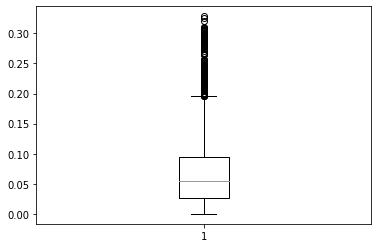

In [28]:
plt.boxplot(data_num["Item_Visibility"])


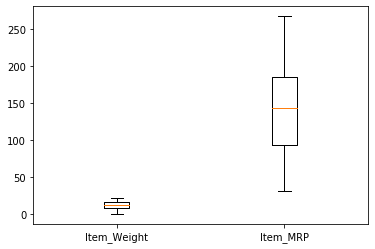

In [29]:
plt.boxplot([data_num["Item_Weight"],data_num["Item_MRP"]])
plt.xticks([1,2],["Item_Weight","Item_MRP"])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1b12b0d6fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b12b0e5710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b12b0d6be0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b12b0e5da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b12b0e5e80>],
 'means': []}

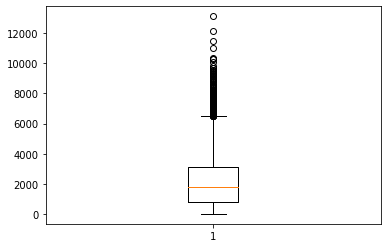

In [30]:
plt.boxplot(data_num["Item_Outlet_Sales"])

In [31]:
q1=data['Item_Outlet_Sales'].quantile(0.25)
q3=data['Item_Outlet_Sales'].quantile(0.75)
IQR=q3-q1
outliers=[]
lower_bound=q1-(1.5*IQR)
higher_bound=q3+(1.5*IQR)
for i in data['Item_Outlet_Sales']:
    if i<lower_bound:
        outliers.append(i)    
for i in data['Item_Outlet_Sales']:
    if i>higher_bound:
        outliers.append(i) 
print(outliers)

[6768.5228, 7968.2944, 6976.2524, 7370.406, 6704.606, 6795.1548, 7222.5984, 7298.4996, 7452.9652, 7696.648, 9267.936, 7763.228, 6911.004, 6687.960999999999, 9158.079, 8114.7704, 7094.7648, 7192.6374, 6611.394, 7443.644, 7488.9184, 7833.8028, 7759.899, 6515.5188, 7017.531999999999, 7370.406, 9133.4444, 9275.9256, 10236.675, 6622.7126, 7152.0236, 7296.5022, 6767.1912, 6872.3876, 7472.2734, 8132.0812, 6897.688, 11445.101999999999, 7646.0472, 6668.6528, 6574.775, 6942.9624, 7073.4592, 7130.718000000001, 6771.186, 7116.0704, 6524.84, 6769.8544, 6692.6216, 6615.3888, 7504.2318, 7086.1094, 7168.6686, 6751.2119999999995, 8239.9408, 9371.8008, 8851.1452, 7478.2656, 8604.7992, 7590.12, 6503.5344, 8760.5964, 6796.4864, 7201.2928, 6852.4136, 6729.9064, 7931.6754, 6729.9064, 7142.7024, 6893.0274, 7534.1928, 7843.124, 9467.676, 8912.3988, 6757.87, 7247.233, 7503.566, 7247.233, 8138.7392, 7033.5112, 7334.4528, 6972.2576, 6851.081999999999, 6641.355, 7350.432, 6507.5292, 8063.5038, 7580.133000000001, 

In [32]:
q1=data['Item_Visibility'].quantile(0.25)
q3=data['Item_Visibility'].quantile(0.75)
IQR=q3-q1
outliers=[]
lower_bound=q1-(1.5*IQR)
higher_bound=q3+(1.5*IQR)
for i in data['Item_Visibility']:
    if i<lower_bound:
        outliers.append(i)    
for i in data['Item_Visibility']:
    if i>higher_bound:
        outliers.append(i) 
print(outliers)

[0.25539489600000004, 0.293417759, 0.278974075, 0.291865402, 0.2047, 0.264124669, 0.228993134, 0.29788371199999997, 0.23303981699999998, 0.21037580600000003, 0.22022560800000002, 0.328390948, 0.20529482699999999, 0.247321039, 0.21413978600000003, 0.227189581, 0.223440258, 0.267352587, 0.25637539, 0.244102315, 0.255348289, 0.224837308, 0.22417463, 0.24554262699999999, 0.23643360100000002, 0.270300331, 0.20471303600000001, 0.32111501, 0.248301532, 0.274405193, 0.20778348300000002, 0.196438668, 0.235354055, 0.241055611, 0.196490902, 0.30374337, 0.23212188, 0.216323008, 0.19842484100000002, 0.213125482, 0.237651344, 0.22206335100000002, 0.294939214, 0.28406587899999997, 0.234733477, 0.309390255, 0.277459381, 0.21332355, 0.253947823, 0.203510667, 0.23661675399999998, 0.205605116, 0.212963193, 0.22846952199999998, 0.23207267399999998, 0.304859104, 0.29182661600000004, 0.242768664, 0.29820527199999997, 0.325780807, 0.266234421, 0.208987123, 0.255929096, 0.24749009, 0.27321283, 0.2081621560000

# Distribution Of Data

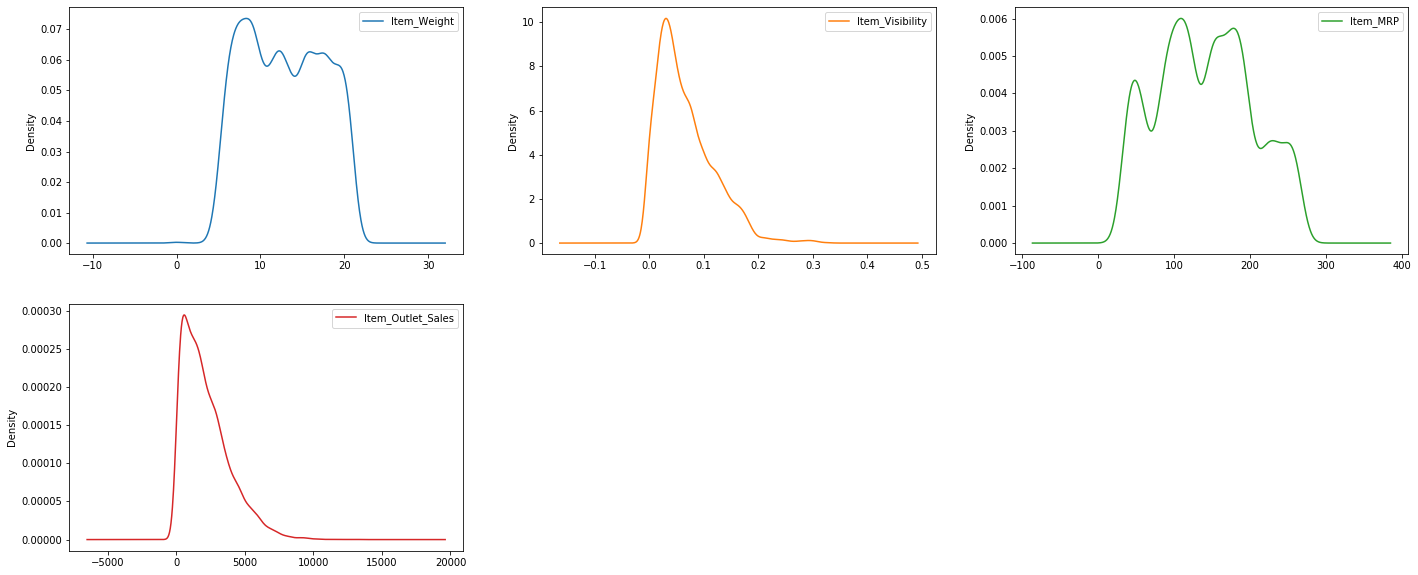

In [33]:
data_num.plot(kind='density',subplots=True,sharex=False,layout=(2,3),figsize=(24,10))
plt.show()

# Skewness and Kurtosis

In [34]:
data_num.skew()

Item_Weight          0.063905
Item_Visibility      1.167091
Item_MRP             0.127202
Item_Outlet_Sales    1.177531
dtype: float64

In [35]:
data_num.kurt()

Item_Weight         -1.214687
Item_Visibility      1.679445
Item_MRP            -0.889769
Item_Outlet_Sales    1.615877
dtype: float64

# Correlation and Covariance

In [36]:
data.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000000,-0.010206,0.026691,0.012979
Item_Visibility,-0.010206,1.000000,-0.001315,-0.128625
Item_MRP,0.026691,-0.001315,1.000000,0.567574
Item_Outlet_Sales,0.012979,-0.128625,0.567574,1.000000


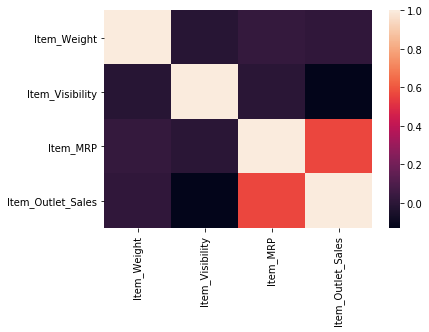

In [37]:
sns.heatmap(data.corr())

# HYPOTHESIS TESTING

# Perform Shapiro and Levene test

In [38]:
test ,p_value = stats.shapiro(data["Item_Outlet_Sales"])
print('P value for shapiro: ',p_value)

P value for shapiro:  0.0


C:\Users\hemak\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [39]:
data['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT046    930
OUT049    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [40]:
c1 = data[data['Outlet_Identifier'] == 'OUT027']['Item_Outlet_Sales']
c2 = data[data['Outlet_Identifier'] == 'OUT013']['Item_Outlet_Sales']
c3 = data[data['Outlet_Identifier'] == 'OUT046']['Item_Outlet_Sales']
c4 = data[data['Outlet_Identifier'] == 'OUT035']['Item_Outlet_Sales']
c5 = data[data['Outlet_Identifier'] == 'OUT049']['Item_Outlet_Sales']
c6 = data[data['Outlet_Identifier'] == 'OUT045']['Item_Outlet_Sales']
c7 = data[data['Outlet_Identifier'] == 'OUT018']['Item_Outlet_Sales']
c8 = data[data['Outlet_Identifier'] == 'OUT017']['Item_Outlet_Sales']
c9 = data[data['Outlet_Identifier'] == 'OUT010']['Item_Outlet_Sales']
c10 = data[data['Outlet_Identifier'] == 'OUT019']['Item_Outlet_Sales']

test, p_val = stats.shapiro(c1)
print('P value for c1: ', p_val)

test, p_val = stats.shapiro(c2)
print('P value for c2: ', p_val)

test, p_val = stats.shapiro(c3)
print('P value for c3: ', p_val)

test, p_val = stats.shapiro(c4)
print('P value for c4: ', p_val)

test, p_val = stats.shapiro(c5)
print('P value for c5: ', p_val)

test, p_val = stats.shapiro(c6)
print('P value for c6: ', p_val)

test, p_val = stats.shapiro(c7)
print('P value for c7: ', p_val)

test, p_val = stats.shapiro(c8)
print('P value for c8: ', p_val)

test, p_val = stats.shapiro(c9)
print('P value for c9: ', p_val)

test, p_val = stats.shapiro(c10)
print('P value for c10: ', p_val)

P value for c1:  5.629242662853661e-17
P value for c2:  5.591113446815663e-20
P value for c3:  1.4358986046094134e-21
P value for c4:  2.3990843382967345e-19
P value for c5:  2.0152556027189664e-20
P value for c6:  8.963528592148546e-23
P value for c7:  2.0043106511704072e-22
P value for c8:  6.539651855572394e-22
P value for c9:  4.023942243297655e-23
P value for c10:  1.31959851701946e-19


Based on Shapiro and Levene test we can easily conclude that this data is not normally distributed, hence we perform the non-parametric test.

# 1.KRUSKAL WALLIS H TEST
#### Now we are going to check whether the average sales for each outlet is same or different.
## The Null and Alternative Hypothesis is:
#### H0: Average sales is same for each outlet.
#### H1: Average sales is different for at least one outlet.

In [41]:
alpha=0.05
test_stat, p_value = stats.kruskal(data[data['Outlet_Identifier'] == 'OUT027']['Item_Outlet_Sales'],
                                   data[data['Outlet_Identifier'] == 'OUT013']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT046']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT035']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT049']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT045']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT018']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT017']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT010']['Item_Outlet_Sales'],
                                    data[data['Outlet_Identifier'] == 'OUT019']['Item_Outlet_Sales'])
print('P_value for Kruskal : ', p_value)
print('Significance level: ',alpha)

P_value for Kruskal :  0.0
Significance level:  0.05


Here P value is less than alpha thus we reject null hypothesis.

And we conclude that average sales is different for at least one outlet.

#### Is it possible to identify which outlets have same average sales? If yes, perform the test at a 5% level of significance.
## Post Hoc Analysis using Conover Test

In [42]:
scikit_posthocs.posthoc_conover(a = data, val_col ='Item_Outlet_Sales', group_col ='Outlet_Identifier')

,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
OUT010,1.000000e+00,3.097381e-251,1.238610e-258,1.868466e-198,9.530372e-01,0.000000e+00,1.782301e-279,1.837440e-234,3.903497e-250,5.494995e-262
OUT013,3.097381e-251,1.000000e+00,4.912316e-01,1.808676e-06,4.042676e-243,3.960456e-61,1.554485e-02,1.458257e-01,9.366128e-01,3.455097e-01
OUT017,1.238610e-258,4.912316e-01,1.000000e+00,4.979012e-08,2.519931e-250,3.325511e-56,8.402479e-02,3.237913e-02,4.428566e-01,7.996162e-01
OUT018,1.868466e-198,1.808676e-06,4.979012e-08,1.000000e+00,6.912523e-192,6.233902e-99,6.935615e-13,9.033376e-04,2.707280e-06,1.121752e-08
OUT019,9.530372e-01,4.042676e-243,2.519931e-250,6.912523e-192,1.000000e+00,0.000000e+00,1.448597e-270,7.739225e-227,4.673785e-242,1.432414e-253
OUT027,0.000000e+00,3.960456e-61,3.325511e-56,6.233902e-99,0.000000e+00,1.000000e+00,3.097998e-45,1.167415e-71,1.261399e-61,1.285724e-54
OUT035,1.782301e-279,1.554485e-02,8.402479e-02,6.935615e-13,1.448597e-270,3.097998e-45,1.000000e+00,1.088624e-04,1.250460e-02,1.400513e-01
OUT045,1.837440e-234,1.458257e-01,3.237913e-02,9.033376e-04,7.739225e-227,1.167415e-71,1.088624e-04,1.000000e+00,1.693780e-01,1.657777e-02
OUT046,3.903497e-250,9.366128e-01,4.428566e-01,2.707280e-06,4.673785e-242,1.261399e-61,1.250460e-02,1.693780e-01,1.000000e+00,3.066357e-01
OUT049,5.494995e-262,3.455097e-01,7.996162e-01,1.121752e-08,1.432414e-253,1.285724e-54,1.400513e-01,1.657777e-02,3.066357e-01,1.000000e+00


Here we observed that p-value are greater than 0.05 for pairs OUT010 and OUT019,
p-value are greater for pairs OUT013,OUT017,OUT035,OUT045,OUT046 and OUT049
we observed OUT018 and OUT027 are different

In [43]:
pd.crosstab(data['Outlet_Identifier'],data['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Identifier,,,,
OUT010,555,0,0,0
OUT013,0,932,0,0
OUT017,0,926,0,0
OUT018,0,0,928,0
OUT019,528,0,0,0
OUT027,0,0,0,935
OUT035,0,930,0,0
OUT045,0,929,0,0
OUT046,0,930,0,0


# 2.ONE WAY ANOVA
### The Null and Alternative Hypothesis is:
### H0:The sales for outlet type  is the same.
### H1:The sales for outlet type is not the same.

In [44]:
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR


In [45]:
df1=data[["Outlet_Type","Item_Outlet_Sales"]]
df1.head()

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type1,3735.1380
1,Supermarket Type2,443.4228
2,Supermarket Type1,2097.2700
3,Grocery Store,732.3800
4,Supermarket Type1,994.7052


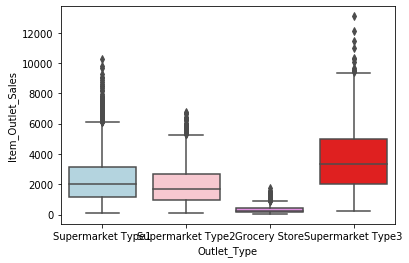

In [46]:
sns.boxplot(x = "Outlet_Type", y = "Item_Outlet_Sales", data = df1,palette=['lightblue','pink','violet','red'])
plt.show()

In [47]:
#Sample of n=50
gs=df1[df1["Outlet_Type"]=='Grocery Store'].sample(30,random_state=12)
sm1=df1[df1["Outlet_Type"]=='Supermarket Type1'].sample(30,random_state=2)
sm2=df1[df1["Outlet_Type"]=='Supermarket Type1'].sample(30,random_state=2)
sm3=df1[df1["Outlet_Type"]=='Supermarket Type1'].sample(30,random_state=2)


In [48]:
# Checking for normality of data at 95% confidence level
print(stats.shapiro(gs["Item_Outlet_Sales"]))
print(stats.shapiro(sm1["Item_Outlet_Sales"]))
print(stats.shapiro(sm2["Item_Outlet_Sales"]))
print(stats.shapiro(sm3["Item_Outlet_Sales"]))

(0.9331113696098328, 0.05942681059241295)
(0.9441890120506287, 0.11796405911445618)
(0.9441890120506287, 0.11796405911445618)
(0.9441890120506287, 0.11796405911445618)


Since p-value is greater 0.05 level of significance we have enough evidence to conclude that the data is normally distributed.

In [49]:
stats.levene(gs["Item_Outlet_Sales"],sm1["Item_Outlet_Sales"],sm2["Item_Outlet_Sales"],sm3["Item_Outlet_Sales"])

LeveneResult(statistic=7.904207227778628, pvalue=7.651324178629501e-05)

Since p_value is greater than 0.05 level of significance we have enough evidence to conclude that the data has equal variance

In [50]:
#Calculating critical value:
crit_val = stats.f.isf(0.05, dfn = 3, dfd = 116)
print("F critical value with 95% confidence:",crit_val)
#Calculating f_statistic and p-value:
f_stat, p_val = stats.f_oneway(gs["Item_Outlet_Sales"],sm1["Item_Outlet_Sales"],sm2["Item_Outlet_Sales"],sm3["Item_Outlet_Sales"])
print("F statistic:",f_stat)
#Calculating p-value
print("P-value:",p_val)

F critical value with 95% confidence: 2.682809407121895
F statistic: 22.770524331758132
P-value: 1.158952205396902e-11


### Post Hoc Analysis using Tuckey's HSD tes

In [51]:
comp = mc.MultiComparison(data = df1["Item_Outlet_Sales"], groups = df1['Outlet_Type'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Grocery Store,Supermarket Type1,1976.3526,0.001,1849.3577,2103.3476,True
Grocery Store,Supermarket Type2,1655.6702,0.001,1484.5971,1826.7434,True
Grocery Store,Supermarket Type3,3354.2101,0.001,3183.4821,3524.938,True
Supermarket Type1,Supermarket Type2,-320.6824,0.001,-456.2679,-185.0969,True
Supermarket Type1,Supermarket Type3,1377.8574,0.001,1242.7077,1513.0071,True
Supermarket Type2,Supermarket Type3,1698.5398,0.001,1521.3288,1875.7508,True


# 3.CHI-SQUARE ONE FACTOR
### The Null and Alternative Hypothesis is:
### H0:as per the managment 56% stores are small, 33% stores are medium and only 11% of the stores are big (high) in size.
### H1: store sizes are different as the claimed ratio.

In [52]:
obs=data['Outlet_Size'].value_counts().values
n=sum(obs)
exp=np.array([n*0.56,n*0.33,n*0.11])

In [53]:
chi_square_stat, p_value = stats.chisquare(obs, f_exp=exp)
print("Chi-square stat:",chi_square_stat)
print("P-value:",p_value)

Chi-square stat: 0.30127340687002835
P-value: 0.8601601351246503


Here p-value is greater than 0.05 thus we can accept the null hypothesis at 5% level of significance and conclude that the ratio of size of the stores is correct as claimed by managment.

# 4.MANN-WHITNEY U TEST¶
### The Null and Alternative Hypothesis are:
### H0: sales for items having low fat is same as items having regular fat.
### H1: sales for items having low fat is greater than  items having regular fat.

In [54]:
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR


In [55]:
reg=data[data["Item_Fat_Content"]=='Regular']['Item_Outlet_Sales']
low_fat=data[data["Item_Fat_Content"]=='Low Fat']['Item_Outlet_Sales']

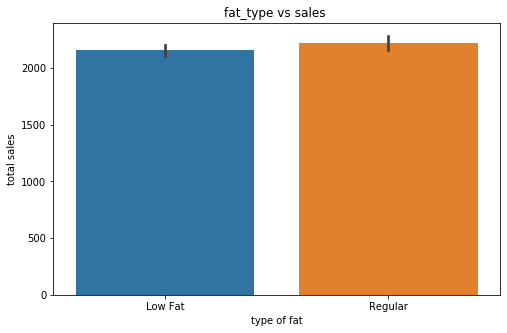

In [56]:
sage1 = data.groupby("Item_Fat_Content", as_index = False)["Item_Outlet_Sales"].mean().sort_values(by="Item_Outlet_Sales",ascending = False)
plt.figure(figsize=(8,5))
sns.barplot(x = "Item_Fat_Content",
            y = "Item_Outlet_Sales",
            data = data)
plt.xlabel("type of fat")
plt.ylabel('total sales')
plt.title('fat_type vs sales ')
plt.show()

In [57]:
#normality test-->shapiro
zstat,pvalue=stats.shapiro(reg)
print('Zstat:',zstat,'P-value:',pvalue)
zstat,pvalue=stats.shapiro(low_fat)
print('Zstat:',zstat,'P-value:',pvalue)

Zstat: 0.9159479141235352 P-value: 5.568419861959685e-38
Zstat: 0.9056128859519958 P-value: 0.0


C:\Users\hemak\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


From the above result, we can see that the p-value is less than 0.05, thus we can say that the sales foe items having low fat and reg fat are not normally distributed .

Since data is not normally distributed here we use non parametric test

In [58]:
test_stat, p_value = stats.mannwhitneyu(reg,low_fat,alternative = 'greater')

# print the test statistic and corresponding p-value
print('Test statistic:', test_stat)
print('p-value:', p_value)

Test statistic: 8480284.0
p-value: 0.041434778958467845


Here the p-value is less than 0.05. Thus we   accept the null hypothesis and we can conclude that item with low fat have greater sale than item with regular fat.

# 5.WILCOXON RANK SUM TEST
### The Null and Alternative Hypothesis are:
### H0: outlet with bigger(high) size is having sales same or less sales compared to small size outlet.
### H1:outlet with bigger(high) size is having greater sales  compared to small size outlet.

In [59]:
df2=data[["Outlet_Size","Item_Outlet_Sales"]]
df2.head()

,Outlet_Size,Item_Outlet_Sales
0,Medium,3735.1380
1,Medium,443.4228
2,Medium,2097.2700
3,Small,732.3800
4,High,994.7052


In [60]:
d1=df2[df2["Outlet_Size"]=="Small"]
d4=df2[df2["Outlet_Size"]=="High"]

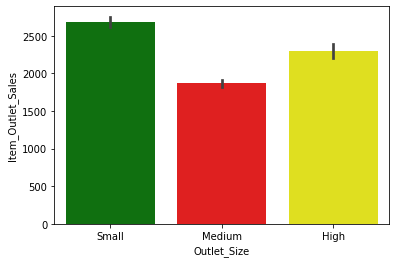

In [61]:
ax=sns.barplot(df2["Outlet_Size"],df2["Item_Outlet_Sales"],palette=['green','red','yellow'])
ax.set_xticklabels(["Small","Medium",'High'])
plt.show()

In [62]:
# Checking for normality of data at 95% confidence level
dtype1=df2[df2["Outlet_Size"]=="Small"].sample(50,random_state=1)
dtype4=df2[df2["Outlet_Size"]=="High"].sample(50,random_state=1)
print(stats.shapiro(dtype1["Item_Outlet_Sales"]))
print(stats.shapiro(dtype4["Item_Outlet_Sales"]))

(0.8545740246772766, 2.0623831005650572e-05)
(0.9097250699996948, 0.0010228264145553112)


Since all the p-values are less than 5% significance level we conclude that the data is not normal

And so we opt for a Non-parametric test

In [63]:
#Calculating Critical value
z_val = round(stats.norm.isf(q = 0.05), 2)
print('Critical value for one-tailed Z-test:', z_val)
test_stat, p_value = stats.ranksums(d1["Item_Outlet_Sales"],d4["Item_Outlet_Sales"])
print("Test stat:",test_stat)

Critical value for one-tailed Z-test: 1.64
Test stat: -9.604592567888163


Since test statistic is less than critical value with 95% confidence it falls in the acceptance region and so we fail to reject the null hypothesis and coclude that sales in big(large) outlets is same or less compared to small out lets.

In [64]:
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR


# 6.CHI-SQUARE TWO FACTOR
#### The Null and Alternative Hypothesis are:
#### H0:  item types sold does not depend on outlet type.
#### H1:  item types sold depends on outlet type.

In [65]:
quality_array = pd.crosstab(index= data['Item_Type'],columns=data['Outlet_Type'])
chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(quality_array)
stats.chi2_contingency(quality_array)

print('Chi-statistic: {} \nP-value: {} \nDegrees of freedom: {}' .format(chi_sq_Stat, p_value,deg_freedom))

Chi-statistic: 21.358383347922537 
P-value: 0.9989342767300661 
Degrees of freedom: 45


Since the p-value(0.9989) greater than 0.05, we accept the null hypothesis. Therefore we can say with 95% confidence that  item type does not depend on outlet type.

### The Null and Alternative Hypothesis are:
#### H0: outlet size  does not depend on outlet type.
#### H1: outlet size depends on outlet type

In [66]:
quality_array = pd.crosstab(index= data['Outlet_Size'],columns=data['Outlet_Type'])
chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(quality_array)
stats.chi2_contingency(quality_array)

print('Chi-statistic: {} \nP-value: {} \nDegrees of freedom: {}' .format(chi_sq_Stat, p_value,deg_freedom))

Chi-statistic: 5379.335956543151 
P-value: 0.0 
Degrees of freedom: 6


Since the p-value(0.0) is less than 0.05, we reject the null hypothesis. Therefore we can say with 95% confidence that outlet size depends on outlet type.

# SIMULATION

In [67]:
def central_limit_theorem(data1,column_names,n_samples = 1000, sample_size = 500):
    min_value = 0 
    max_value = data1.count()  
    b = {}
    for i in range(n_samples):
        x = np.unique(np.random.randint(min_value, max_value, size = sample_size)) 
        b[i] = data1[x].mean()   
    c = pd.DataFrame()
    c['sample'] = b.keys()   
    c['Mean'] = b.values()  
    plt.figure(figsize= (15,5))

    plt.subplot(1,2,2)
    sns.distplot(c.Mean,color='green')
    plt.title(f"Sampling Distribution. \n \u03bc = {round(c.Mean.mean(), 3)} & SE = {round(c.Mean.std(),3)}")
    plt.xlabel(column_names)
    plt.ylabel('freq')

    plt.subplot(1,2,1)
    sns.distplot(data1,color='red')
    plt.title(f"Population Distribution. \n \u03bc = {round(data1.mean(), 3)} & \u03C3 = {round(data1.std(),3)}")
    plt.xlabel(column_names)
    plt.ylabel('freq')

    plt.show()

In [68]:
series1 = data['Item_MRP']
series2 = data['Item_Outlet_Sales']

# Simulation with sample size = 500 and no of samples = 20

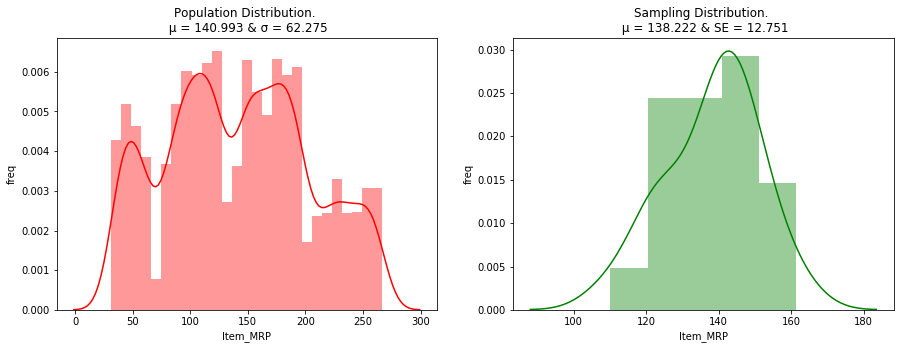

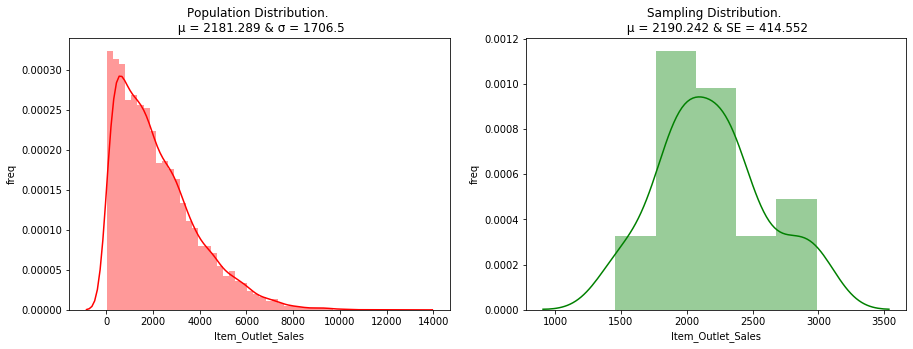

In [69]:
central_limit_theorem(series1,'Item_MRP',n_samples = 20, sample_size = 20)
central_limit_theorem(series2,"Item_Outlet_Sales",n_samples =20, sample_size = 20)

# Simulation with sample size = 500 and no of samples = 500

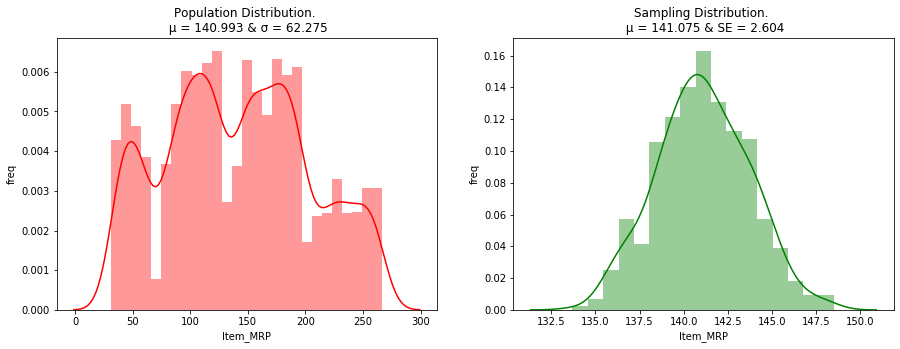

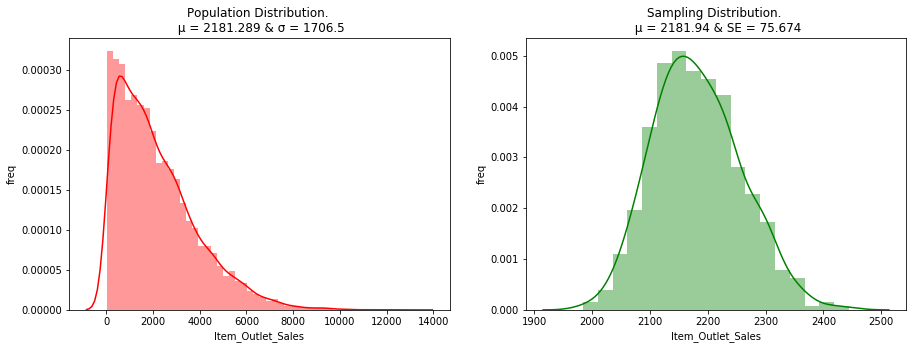

In [70]:
central_limit_theorem(series1,'Item_MRP',n_samples = 500, sample_size = 500)
central_limit_theorem(series2,"Item_Outlet_Sales",n_samples = 500, sample_size = 500)

In [71]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC


In [72]:
alpha=0.05
test_stat, p_value = stats.kruskal(data[data['Item_Fat_Content'] == 'Low Fat']['Item_Outlet_Sales'],
                                   data[data['Item_Fat_Content'] == 'Regular']['Item_Outlet_Sales'])
print('P_value for Kruskal : ', p_value)
print('Significance level: ',alpha)

P_value for Kruskal :  0.08286874092719329
Significance level:  0.05


In [73]:
pd.crosstab(index= data['Item_Type'],columns=data['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Type,,,,
Baking Goods,85,426,68,69
Breads,33,160,27,31
Breakfast,19,68,12,11
Canned,73,426,78,72
Dairy,92,450,73,67
Frozen Foods,103,572,92,89
Fruits and Vegetables,152,805,135,140
Hard Drinks,24,145,22,23
Health and Hygiene,67,335,58,60


In [74]:
 pd.crosstab(index= data['Outlet_Size'],columns=data['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,1083,3715,0,0
